In [1]:
!pip install -q prophet==1.2.1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

In [3]:
# Path data
data_path = "/content/drive/MyDrive/ColabNotebooks/VisDatLanjut/Final Project/Data Cuaca BMKG Kota Bandung 2024-25.xlsx"
df_raw = pd.read_excel(data_path)

# Rename kolom agar konsisten & mudah dipakai
df_raw = df_raw.rename(columns={
    "TANGGAL": "Date",
    "TN": "Temp_Min",
    "TX": "Temp_Max",
    "TAVG": "Temp_Avg",
    "RH_AVG": "Humidity",
    "RR": "Rain",
    "SS": "Sunshine",
    "FF_X": "Wind_Max",
    "DDD_X": "Wind_Dir_Max",
    "FF_AVG": "Wind_Avg",
    "DDD_CAR": "Wind_Dir_Dom"
})

df_raw["Date"] = pd.to_datetime(df_raw["Date"], format="%d-%m-%Y", errors="coerce")

print(df_raw.head())

        Date  Temp_Min  Temp_Max  Temp_Avg  Humidity  Rain  Sunshine  \
0 2024-01-01      20.8      30.0      25.3      81.0  37.1       4.1   
1 2024-01-02      22.4      30.4      25.6      82.0   3.8       2.7   
2 2024-01-03      22.4      28.8      24.9      83.0   6.4       1.1   
3 2024-01-04      22.0      26.8      22.5      91.0   1.6       1.4   
4 2024-01-05      20.2      29.6      23.9      82.0  32.5       0.0   

   Wind_Max  Wind_Dir_Max  Wind_Avg Wind_Dir_Dom  
0         3            24         0           C   
1         1            90         0           C   
2         3           280         1           C   
3         2           120         0           C   
4         5           210         0           C   


In [4]:
# Group per hari (jaga-jaga jika ada duplikasi)
df = df_raw.groupby("Date", as_index=False).mean(numeric_only=True)

# Set index & frequency harian
df = df.set_index("Date").asfreq("D")
df.index.freq = "D"

In [5]:
BMKG_MISSING_CODE = 8888

for col in ["Rain", "Temp_Min", "Temp_Max", "Temp_Avg", "Humidity", "Sunshine"]:
    df.loc[df[col] == BMKG_MISSING_CODE, col] = np.nan

In [8]:
def prophet_impute_safe(series):
    """
    Imputasi hanya untuk nilai NaN menggunakan Prophet (AMAN & INDEX-SAFE).
    Data asli TIDAK ditimpa.
    """
    # Copy supaya tidak mengubah data asli
    s = series.copy()

    # Kalau semua NaN → skip
    if s.isna().all():
        return s

    # Siapkan data Prophet
    temp = pd.DataFrame({
        "ds": s.index,
        "y": s.values
    })

    # Fit hanya pada data non-NaN
    model = Prophet(
        daily_seasonality=True,
        yearly_seasonality=True
    )
    model.fit(temp.dropna())

    # Predict full range
    forecast = model.predict(temp)

    # Ambil yhat sebagai array
    yhat = forecast["yhat"].values

    # Isi hanya posisi NaN
    s.iloc[s.isna().values] = yhat[s.isna().values]

    return s

In [15]:
# Variabel kontinu → Prophet
for col in ["Temp_Min", "Temp_Max", "Temp_Avg", "Humidity", "Rain", "Sunshine"]:
    df[col] = prophet_impute_safe(df[col])
    df[col] = df[col].round(1)

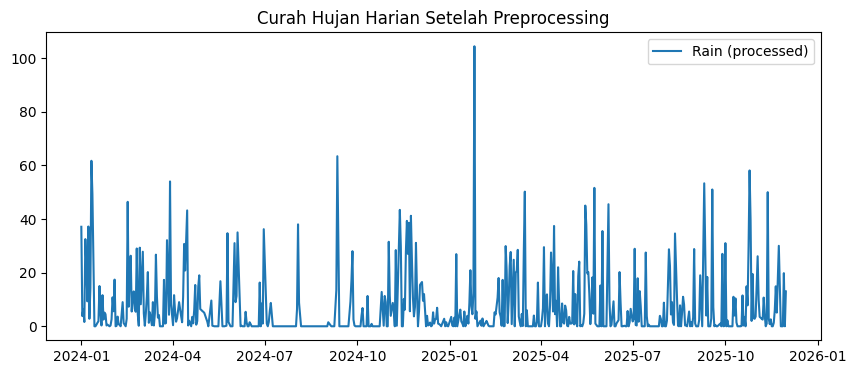

In [16]:
plt.figure(figsize=(10,4))
plt.plot(df.index, df["Rain"], label="Rain (processed)")
plt.title("Curah Hujan Harian Setelah Preprocessing")
plt.legend()
plt.show()

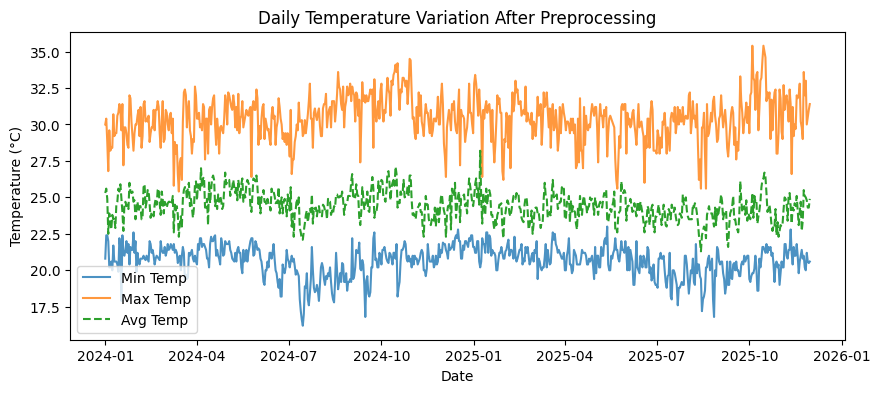

In [21]:
plt.figure(figsize=(10,4))
plt.plot(df.index, df["Temp_Min"], label="Min Temp", alpha=0.8)
plt.plot(df.index, df["Temp_Max"], label="Max Temp", alpha=0.8)
plt.plot(df.index, df["Temp_Avg"], label="Avg Temp", linestyle="--")

plt.title("Daily Temperature Variation After Preprocessing")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()

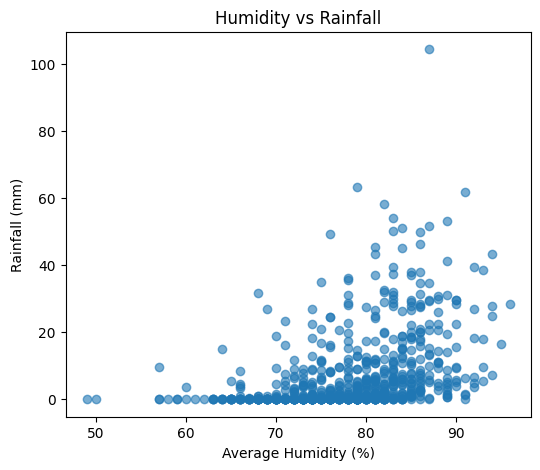

In [22]:
plt.figure(figsize=(6,5))
plt.scatter(df["Humidity"], df["Rain"], alpha=0.6)
plt.xlabel("Average Humidity (%)")
plt.ylabel("Rainfall (mm)")
plt.title("Humidity vs Rainfall")
plt.show()

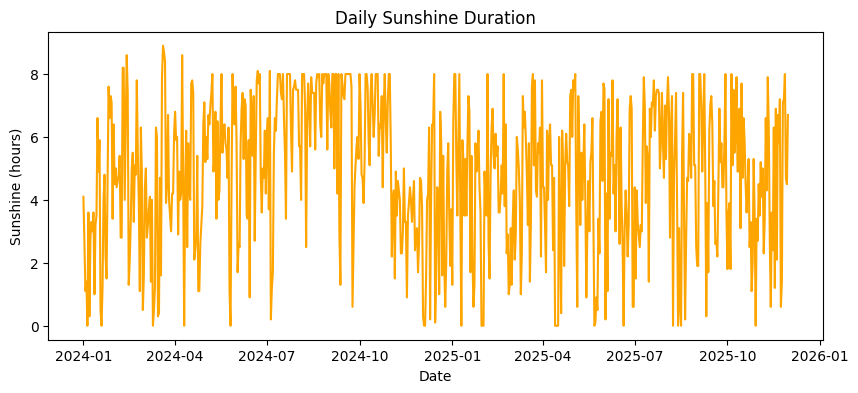

In [23]:
plt.figure(figsize=(10,4))
plt.plot(df.index, df["Sunshine"], color="orange")
plt.title("Daily Sunshine Duration")
plt.xlabel("Date")
plt.ylabel("Sunshine (hours)")
plt.show()

In [27]:
def classify_weather_6(rr, rh, ss):
    """
    Simplified BMKG daily weather classification into 6 categories.

    Parameters
    ----------
    rr : float
        Daily rainfall (mm)
    rh : float
        Average relative humidity (%)
    ss : float
        Sunshine duration (hours)

    Returns
    -------
    str
        Weather category:
        - Sunny
        - Partly Cloudy
        - Cloudy
        - Light Rain
        - Moderate Rain
        - Heavy Rain
    """

    # ---- Rain conditions ----
    if rr > 0:
        if rr <= 20:
            return "Light Rain"
        elif rr <= 50:
            return "Moderate Rain"
        else:
            return "Heavy Rain"

    # ---- No rain: sky condition ----
    if ss >= 7 and rh < 75:
        return "Sunny"
    elif 4 <= ss < 7:
        return "Partly Cloudy"
    else:
        return "Cloudy"

# def classify_bmkg_10(rr, rh, ss, tn, tx, tavg, ff_avg, ff_x):
#     # handle missing
#     if rr is None or rh is None or ss is None or tn is None or tx is None or ff_avg is None or ff_x is None:
#         return "Berawan"  # fallback aman

#     dtr = tx - tn  # diurnal temp range

#     # 1) Rain-based first (lebih “keras”)
#     if rr > 0:
#         # Thunderstorm proxy
#         if rr > 20 and ff_x >= 8:
#             return "Hujan Petir"
#         if rr <= 20:
#             return "Hujan Ringan"
#         elif rr <= 50:
#             return "Hujan Sedang"
#         else:
#             return "Hujan Lebat"

#     # 2) No-rain cases: fog / haze / cloudiness
#     # Fog proxy
#     if (rh >= 95) and (ss <= 1) and (ff_avg <= 2) and (dtr <= 4):
#         return "Kabut"

#     # Haze proxy (weak)
#     if (ss <= 2) and (rh <= 80) and (ff_avg <= 3):
#         return "Asap"

#     # Cloudiness based on ss & rh
#     # Threshold ss ini perlu disesuaikan dengan konteks (mis. musim hujan vs kemarau)
#     if ss >= 7 and rh <= 75:
#         return "Cerah"
#     if ss >= 4 and ss < 7:
#         return "Cerah Berawan"
#     if ss >= 1 and ss < 4:
#         return "Berawan"
#     return "Berawan Total"


In [28]:
df["Weather_Class"] = df.apply(
    lambda r: classify_weather_6(
        rr=r["Rain"],
        rh=r["Humidity"],
        ss=r["Sunshine"]
    ),
    axis=1
)

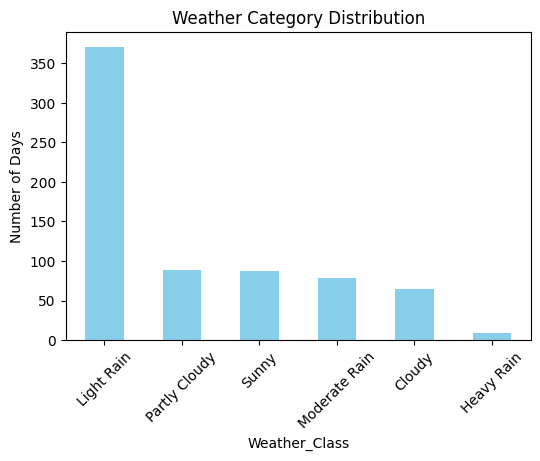

In [29]:
weather_counts = df["Weather_Class"].value_counts()

plt.figure(figsize=(6,4))
weather_counts.plot(kind="bar", color="skyblue")
plt.title("Weather Category Distribution")
plt.ylabel("Number of Days")
plt.xticks(rotation=45)
plt.show()

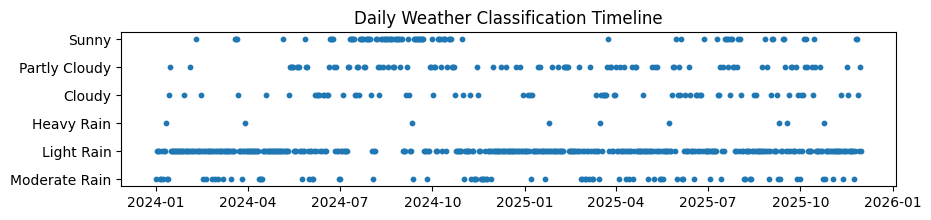

In [30]:
plt.figure(figsize=(10,2))
plt.scatter(df.index, df["Weather_Class"], s=10)
plt.title("Daily Weather Classification Timeline")
plt.yticks(rotation=0)
plt.show()

In [31]:
final_columns = [
    "Temp_Min", "Temp_Max", "Temp_Avg",
    "Humidity", "Rain", "Sunshine",
    "Wind_Max", "Wind_Avg",
    "Weather_Class"
]

df_final = df[final_columns].copy()
df_final.to_csv('/content/drive/MyDrive/ColabNotebooks/VisDatLanjut/Final Project/weather_bandung_2024_25.csv')
print(df_final.head())

            Temp_Min  Temp_Max  Temp_Avg  Humidity  Rain  Sunshine  Wind_Max  \
Date                                                                           
2024-01-01      20.8      30.0      25.3      81.0  37.1       4.1       3.0   
2024-01-02      22.4      30.4      25.6      82.0   3.8       2.7       1.0   
2024-01-03      22.4      28.8      24.9      83.0   6.4       1.1       3.0   
2024-01-04      22.0      26.8      22.5      91.0   1.6       1.4       2.0   
2024-01-05      20.2      29.6      23.9      82.0  32.5       0.0       5.0   

            Wind_Avg  Weather_Class  
Date                                 
2024-01-01       0.0  Moderate Rain  
2024-01-02       0.0     Light Rain  
2024-01-03       1.0     Light Rain  
2024-01-04       0.0     Light Rain  
2024-01-05       0.0  Moderate Rain  


In [32]:
df_final

,Temp_Min,Temp_Max,Temp_Avg,Humidity,Rain,Sunshine,Wind_Max,Wind_Avg,Weather_Class
Date,,,,,,,,,
2024-01-01,20.8,30.0,25.3,81.0,37.1,4.1,3.0,0.0,Moderate Rain
2024-01-02,22.4,30.4,25.6,82.0,3.8,2.7,1.0,0.0,Light Rain
2024-01-03,22.4,28.8,24.9,83.0,6.4,1.1,3.0,1.0,Light Rain
2024-01-04,22.0,26.8,22.5,91.0,1.6,1.4,2.0,0.0,Light Rain
2024-01-05,20.2,29.6,23.9,82.0,32.5,0.0,5.0,0.0,Moderate Rain
...,...,...,...,...,...,...,...,...,...
2025-11-26,20.0,33.0,25.0,72.0,0.0,7.2,2.0,0.0,Sunny
2025-11-27,21.2,30.0,24.8,78.0,0.0,8.0,4.0,0.0,Cloudy
2025-11-28,20.6,30.5,24.3,78.0,19.8,4.7,2.0,0.0,Light Rain
